# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar dependencias
Para esta tarea, se han agregado algunos requerimientos, asegúrese de instalarlos (puede usar el mismo entorno virtual de la Tarea 1):

In [1]:
!pip install jupyter pandas "sqlalchemy<2.0" pymysql seaborn pillow scikit-learn

  Using cached PyMySQL-1.1.1-py3-none-any.whl.metadata (4.4 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.6 MB 330.3 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.6 MB 655.4 kB/s eta 0:00:03
   ------------- -------------------------- 0.6/1.6 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 7.3 MB/s eta 0:00:00
Using cached PyMySQL-1.1.1-py3-none-any.whl (44 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)
  At

In [24]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Conexión a la Base y Lectura de Datos

In [8]:
df_paragraphs = pd.read_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\paragraphs.csv")
df_characters = pd.read_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\characters.csv")
df_works = pd.read_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\works.csv")
df_chapters = pd.read_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\chapters.csv")

## Limpieza de Texto

In [25]:
# Eliminamos signos de puntuacion, exclamacion, pregunta, etc

def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # FIXME: completar
    for punc in ["[", "\n", ",", ":",";","]", "!", "?", ".", "-",'"','#', '$', '%', '&', '(', ')', '*']:
        result = result.str.replace(punc, " ")
    return result

# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Veamos la diferencia
df_paragraphs[["PlainText", "CleanText"]]

,PlainText,CleanText
0,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",enter duke orsino curio and other lords mu...
1,"If music be the food of love, play on;\r\nGive...",if music be the food of love play on \r give ...
2,"Will you go hunt, my lord?",will you go hunt my lord
3,"What, Curio?",what curio
4,The hart.,the hart
...,...,...
35460,"That she is living,\r\nWere it but told you, s...",that she is living \r were it but told you sh...
35461,"You gods, look down\r\nAnd from your sacred vi...",you gods look down\r and from your sacred via...
35462,There's time enough for that;\r\nLest they des...,there's time enough for that \r lest they desi...
35463,"O, peace, Paulina!\r\nThou shouldst a husband ...",o peace paulina \r thou shouldst a husband t...


In [26]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
characters = ["Antony", "Cleopatra", "Queen Margaret"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
2058,if it be love indeed tell me how much,Cleopatra,Antony and Cleopatra,Tragedy
2059,there's beggary in the love that can be reckon'd,Antony,Antony and Cleopatra,Tragedy
2060,i'll set a bourn how far to be beloved,Cleopatra,Antony and Cleopatra,Tragedy
2061,then must thou needs find out new heaven new ...,Antony,Antony and Cleopatra,Tragedy
2064,grates me the sum,Antony,Antony and Cleopatra,Tragedy
...,...,...,...,...
27583,thou hadst a clarence too and richard kill'd ...,Queen Margaret,Richard III,History
27585,bear with me i am hungry for revenge \r and n...,Queen Margaret,Richard III,History
27587,i call'd thee then vain flourish of my fortune...,Queen Margaret,Richard III,History
27589,forbear to sleep the nights and fast the days...,Queen Margaret,Richard III,History


In [33]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()
df_dataset.to_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\dataset.csv")

## Dataset y Features de texto

In [27]:
X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

In [28]:
# TODO: Partir train/test 30% estratificados

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

Tamaños de Train/Test: 438/188


### Conteo de palabras y TF-IDF

In [29]:
count_vect = CountVectorizer(stop_words=None, ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts

<438x2807 sparse matrix of type '<class 'numpy.int64'>'
	with 10831 stored elements in Compressed Sparse Row format>

In [30]:
tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)
X_train_tf

<438x2807 sparse matrix of type '<class 'numpy.float64'>'
	with 10831 stored elements in Compressed Sparse Row format>

In [28]:
# guardamos datos generados para utilizar en rmarkdown

#df_X_train=pd.DataFrame(X_train)
#df_X_test=pd.DataFrame(X_test)
#df_y_train=pd.DataFrame(y_train)
#df_y_test=pd.DataFrame(y_test)

#df_X_train.to_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\X_train.csv")
#df_X_test.to_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\X_test.csv")
#df_y_train.to_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\y_train.csv")
#df_y_test.to_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\y_test.csv")

### Reducción de dimensionalidad

In [31]:
# TODO: Realizar PCA sobre los datos de entrenamiento

from sklearn.decomposition import PCA

reductor = PCA(n_components=2)

# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

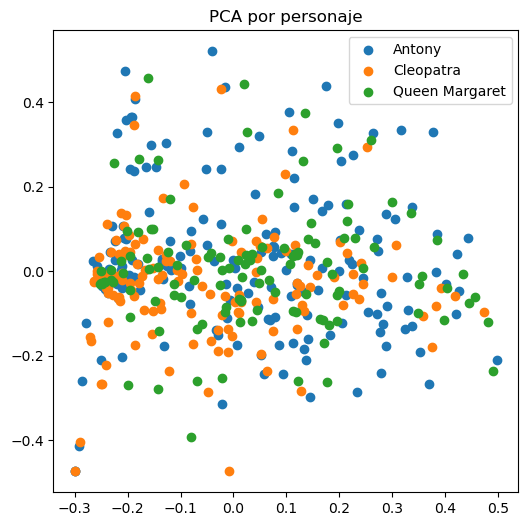

In [32]:
# Visualización de las dos primeras componentes de PCA
fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()

In [35]:
# varianza explicada
reductor.explained_variance_ratio_

array([0.04308257, 0.02689726])

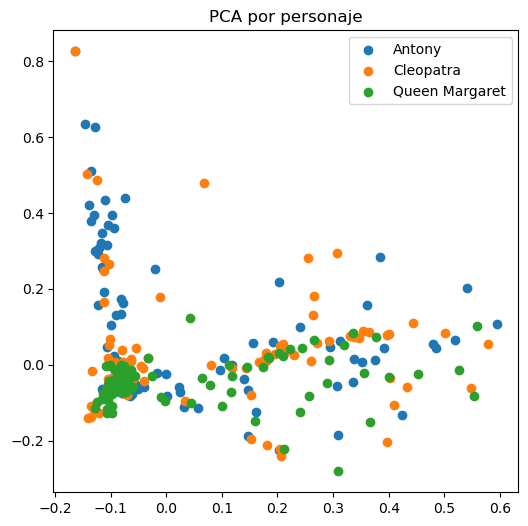

In [36]:
# idem filtrando las stopwords en ingles
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train)

tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)

from sklearn.decomposition import PCA

reductor = PCA(n_components=2)

# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()

In [37]:
# varianza explicada
reductor.explained_variance_ratio_

array([0.02985894, 0.01863092])

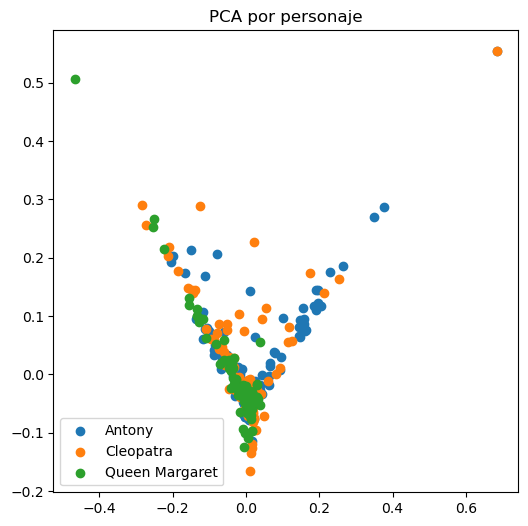

In [38]:
# idem filtrando las stopwords en ingles, el parametro use idf en true y ngram rnge 12
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(X_train)

tf_idf = TfidfTransformer(use_idf=True)
X_train_tf = tf_idf.fit_transform(X_train_counts)

from sklearn.decomposition import PCA

reductor = PCA(n_components=2)

# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()

In [39]:
# varianza explicada
reductor.explained_variance_ratio_

array([0.00844013, 0.00793305])

In [105]:
X_train_tf
print(X_train_tf[1,:])

## Modelos de Clasificación

In [49]:
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

array(['Queen Margaret', 'Antony', 'Cleopatra', 'Antony', 'Cleopatra',
       'Cleopatra', 'Antony', 'Cleopatra', 'Antony', 'Antony'],
      dtype='<U14')

In [63]:
# prediccion en el conjunto de testeo
# idem filtrando las stopwords en ingles, el parametro use idf en true y ngram rnge 12
#count_vect = CountVectorizer(stop_words='english', ngram_range=(1,2))

X_test_counts = count_vect.transform(X_test)

X_test_tf = tf_idf.transform(X_test_counts)


In [65]:
y_pred_test = bayes_clf.predict(X_test_tf)

y_pred_test[:10]

array(['Antony', 'Cleopatra', 'Antony', 'Cleopatra', 'Antony', 'Antony',
       'Antony', 'Cleopatra', 'Antony', 'Antony'], dtype='<U14')

In [83]:
# accuracy en los datos de entrenamiento
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

acc_train = get_accuracy(y_train, y_pred_train)
acc_train

0.9634703196347032

In [84]:
#accuracy en los datos de testeo
acc_testeo = get_accuracy(y_test, y_pred_test)
acc_testeo

0.574468085106383

In [86]:
# TODO: Predecir para test y ver la matriz de confusión, y reportar accuracy

# X_test_counts = ...
# X_test_tfidf = ...
# y_test_pred = ...

from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_pred_test)
matriz

array([[69,  6,  1],
       [40, 21,  0],
       [30,  3, 18]], dtype=int64)

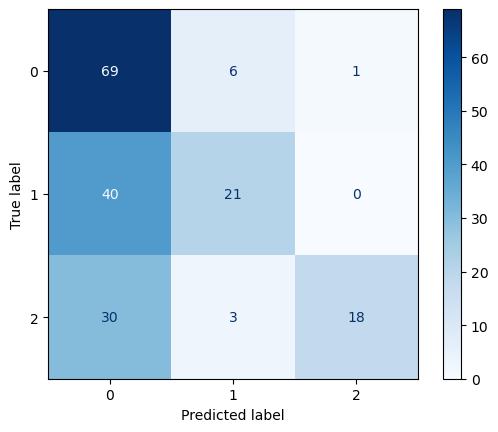

In [92]:
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot(cmap = plt.cm.Blues)
plt.show()

In [85]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_test, average=None)


array([0.90789474, 0.3442623 , 0.35294118])

In [93]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_test, average=None)

array([0.64186047, 0.46153846, 0.51428571])

### Búsqueda de hiper-parámetros con Cross-Validation

In [106]:
from sklearn.model_selection import StratifiedKFold

# TODO: Agregar más variantes de parámetros que les parezcan relevantes
param_sets = [{"stop_words": None, "ngram": (1,2), "idf": True},
             {"stop_words": None, "ngram": (1,1), "idf": False},
             {"stop_words": 'english', "ngram": (1,2), "idf": True}]

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Ahora usaremos train/validation/test
# Por lo tanto le renombramos train+validation = dev(elopment) dataset
X_dev = X_train
y_dev = y_train

# # Para evitar errores
# del X_train
# del y_train

for params in param_sets:
    
    # Transormaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])
    
    for train_idxs, val_idxs in skf.split(X_dev, y_dev):
        
        # Train y validation para el split actual
        X_train_ = X_dev[train_idxs]
        y_train_ = y_dev[train_idxs]
        X_val = X_dev[val_idxs]
        y_val = y_dev[val_idxs]
        
        # Ajustamos y transformamos Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)
        
        # TODO: Completar el código para entrenar y evaluar 
        
        # Entrenamos con Train
        bayes_clf = MultinomialNB().fit(X_train_tf, y_train_)

        # Transformamos Validation
        # X_val_counts = ...
        # X_val_tfidf = ...
        X_val_counts = count_vect.transform(X_val)
        X_val_tfidf = tf_idf.transform(X_val_counts)
        
        # Predecimos y evaluamos en Validation
        y_pred_val = bayes_clf.predict(X_val_tfidf)
        acc = get_accuracy(y_val, y_pred_val)
        print(f"{acc=:.4f} {params=}")



acc=0.4364 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.4909 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.5046 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.4495 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.4364 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4545 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4954 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4220 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.5455 params={'stop_words': 'english', 'ngram': (1, 2), 'idf': True}
acc=0.5727 params={'stop_words': 'english', 'ngram': (1, 2), 'idf': True}
acc=0.5505 params={'stop_words': 'english', 'ngram': (1, 2), 'idf': True}
acc=0.5229 params={'stop_words': 'english', 'ngram': (1, 2), 'idf': True}


In [107]:
# MODELO SELECCIONADO
# modelo con mayor accuracy
count_vect = CountVectorizer(stop_words='english', ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(X_train)

tf_idf = TfidfTransformer(use_idf=True)
X_train_tf = tf_idf.fit_transform(X_train_counts)

bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

X_test_counts = count_vect.transform(X_test)

X_test_tf = tf_idf.transform(X_test_counts)

y_pred_test = bayes_clf.predict(X_test_tf)

y_pred_test[:10]

acc_testeo = get_accuracy(y_test, y_pred_test)
acc_testeo

0.574468085106383

In [108]:

acc_train = get_accuracy(y_train, y_pred_train)

acc_train

0.9634703196347032

In [115]:
#IMPLEMENTACION RED NEURONAL

# paso 1 importamos paquetes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [116]:
model = Sequential()
# Add the layers
model.add(Dense(12057, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.fit(X_train_tf, y_train, epochs=1000)
# batch_size = un numero es cruciar cuando el data set es muy grande


In [117]:
X_train_tf

<438x8489 sparse matrix of type '<class 'numpy.float64'>'
	with 12097 stored elements in Compressed Sparse Row format>

In [114]:

# paso 2 definimos capas
capaentrada = tf.keras.layers.Dense(units = 8, input_shape = [8])
capaoculta = tf.keras.layers.Dense(units = 8)
capasalida = tf.keras.layers.Dense(units = 1)

modelo = tf.keras.Sequential(capaentrada, capaoculta, capasalida)

modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0,1),
    loss = 'categorical_crossentropy',
    metrics = 'accuracy'
)

print('inicio del entrenamiento...')
historial = modelo.fit(X_train_tf, y_train, epochs = 1000, verbose = False, validation_split = 0.2)
print('modelo entrenado')


### (Opcional) Comparativa con Fasttext

In [98]:
!pip install fasttext

     ---------------------------------------- 0.0/73.4 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/73.4 kB ? eta -:--:--
     --------------- ---------------------- 30.7/73.4 kB 262.6 kB/s eta 0:00:01
     ------------------------------- ------ 61.4/73.4 kB 409.6 kB/s eta 0:00:01
     -------------------------------------- 73.4/73.4 kB 448.2 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pybind11-2.12.0-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
Failed to build fasttext


  error: subprocess-exited-with-error
  
  × Building wheel for fasttext (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      C:\Users\lucia\AppData\Local\Temp\pip-build-env-8jatbbw7\overlay\Lib\site-packages\setuptools\dist.py:476: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              By 2024-Sep-26, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
        

In [99]:
import fasttext

y_train_s = np.char.replace(y_train.astype(str), " ", "_").astype(object)
y_test_s = np.char.replace(y_test.astype(str), " ", "_").astype(object)

# Convertimos al formato de fasttext: archivo de texto donde cada línea es:
# __label__<label> TEXTO
Xytrains = "__label__" + y_train_s.astype(object) + " " + X_train
Xytests = "__label__" + y_test_s.astype(object) + " " + X_test
np.savetxt(data_dir / "train.txt", Xytrains, fmt="%s")
np.savetxt(data_dir / "test.txt", Xytests, fmt="%s")

Xytests[0]

ModuleNotFoundError: No module named 'fasttext'

In [ ]:
model = fasttext.train_supervised(input=str(data_dir / "train.txt"), epoch=100, wordNgrams=2)
model.test(str(data_dir / "test.txt"))

In [ ]:
y_out = model.predict(list(X_test))
y_pred_test = [y[0].replace("__label__", "") for y in y_out[0]]
    
print(get_accuracy(y_test_s, y_pred_test))

In [11]:
# cambio de personaje
# Usaremos sólo estos personajes: cambiamos a Antony por Poet
# Agregamos personajes, obras y géneros en el mismo dataset

df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
characters = ["Poet", "Cleopatra", "Queen Margaret"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
2058,if it be love indeed tell me how much,Cleopatra,Antony and Cleopatra,Tragedy
2060,i'll set a bourn how far to be beloved,Cleopatra,Antony and Cleopatra,Tragedy
2065,nay hear them antony \r fulvia perchance is ...,Cleopatra,Antony and Cleopatra,Tragedy
2067,perchance nay and most like \r you must not ...,Cleopatra,Antony and Cleopatra,Tragedy
2069,excellent falsehood \r why did he marry fulvia...,Cleopatra,Antony and Cleopatra,Tragedy
...,...,...,...,...
34648,by this the boy that by her side lay kill'd\r...,Poet,Venus and Adonis,Poem
34649,she bows her head the new sprung flower to sm...,Poet,Venus and Adonis,Poem
34650,'poor flower ' quoth she 'this was thy father...,Poet,Venus and Adonis,Poem
34651,'here was thy father's bed here in my breast ...,Poet,Venus and Adonis,Poem


Tamaños de Train/Test: 797/342


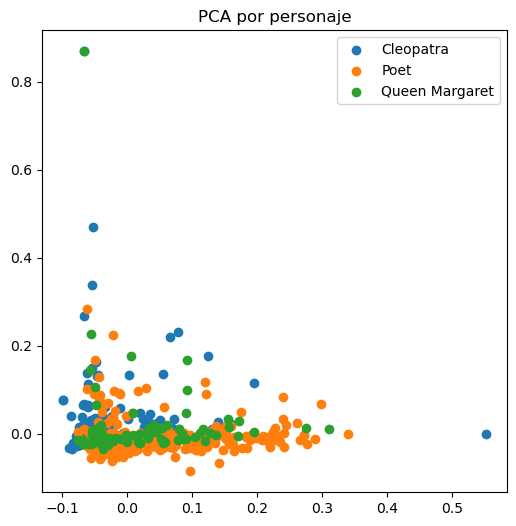

In [14]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()
df_dataset.to_csv(r"C:\Users\lucia\OneDrive\Escritorio\IntroCD\Tarea2_introCD\Tarea_2\data\shakespeare\dataset_poet.csv")

X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

count_vect = CountVectorizer(stop_words=None, ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train)

tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)

from sklearn.decomposition import PCA

reductor = PCA(n_components=2)

# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

count_vect = CountVectorizer(stop_words='english', ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(X_train)

tf_idf = TfidfTransformer(use_idf=True)
X_train_tf = tf_idf.fit_transform(X_train_counts)

from sklearn.decomposition import PCA

reductor = PCA(n_components=2)

# Transformar train
X_train_red = reductor.fit_transform(X_train_tf.toarray())

fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()

In [20]:
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

X_test_counts = count_vect.transform(X_test)

X_test_tf = tf_idf.transform(X_test_counts)

y_pred_test = bayes_clf.predict(X_test_tf)

y_pred_test[:10]

def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

acc_train = get_accuracy(y_train, y_pred_train)
acc_train


0.7114178168130489

In [16]:
acc_testeo = get_accuracy(y_test, y_pred_test)
acc_testeo


0.672514619883041

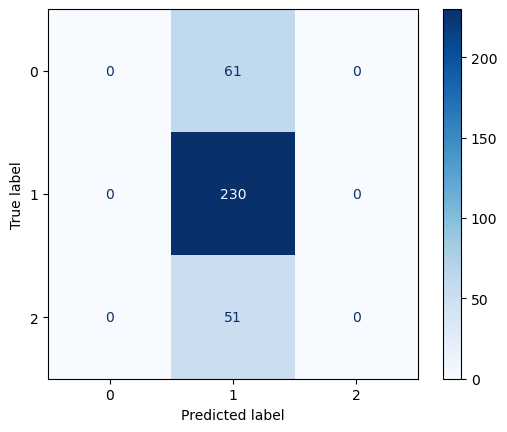

In [23]:

from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_pred_test)
matriz

disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot(cmap = plt.cm.Blues)
plt.show()


In [18]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_test, average=None)

array([0., 1., 0.])

In [19]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_test, average=None)

array([0.       , 0.8041958, 0.       ])